## Contents:
1. **[Cleaning Data](#Cleaning)**
2. **[Feature Importance using Decision Tree](#Decision)**
3. **[Feature Importance using Random Forest Regression](#Forest)**

<a id="Cleaning"></a>
## Cleaning Data

Import required libraries

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Import the data

In [2]:
cols = [
    "id",
    "host_is_superhost",
    "host_total_listings_count",
    "host_identity_verified",
    "accommodates",
    "bathrooms_text",
    "bedrooms",
    "beds",
    "price",
    "minimum_nights",
    "availability_365",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_accuracy",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "instant_bookable",
    
]

df = pd.read_csv("listings 2.csv", usecols=cols)

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
df.isna().sum()

id                                 0
host_is_superhost                 59
host_total_listings_count         59
host_identity_verified            59
accommodates                       0
bathrooms_text                   244
bedrooms                        4017
beds                            3646
price                              0
minimum_nights                     0
availability_365                   0
number_of_reviews                  0
review_scores_rating           18559
review_scores_accuracy         19877
review_scores_cleanliness      19866
review_scores_checkin          19916
review_scores_communication    19880
review_scores_location         19917
instant_bookable                   0
dtype: int64

Drop NaN values

In [5]:
df = df.dropna(subset = ["host_is_superhost", "host_total_listings_count", "bathrooms_text", "bedrooms", "beds"])

df

,id,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable
1,15400,f,1.0,t,2,1 bath,1.0,1.0,$75.00,3,4,89,4.79,4.84,4.88,4.87,4.82,4.93,f
2,17402,f,18.0,t,6,2 baths,3.0,3.0,$265.00,4,295,43,4.69,4.80,4.68,4.66,4.66,4.85,f
3,17506,f,3.0,t,2,1 private bath,1.0,1.0,$150.00,3,364,0,NaN,NaN,NaN,NaN,NaN,NaN,f
5,33332,f,2.0,t,2,1 private bath,1.0,1.0,$65.00,2,362,11,4.55,4.50,4.60,4.70,4.80,4.80,f
6,36299,f,1.0,t,5,1.5 baths,3.0,3.0,$195.00,3,300,86,4.82,4.81,4.80,4.94,4.96,4.90,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66636,53709893,t,13.0,t,6,1 bath,3.0,3.0,$120.00,2,253,0,NaN,NaN,NaN,NaN,NaN,NaN,f
66637,53710986,f,9.0,t,8,2.5 baths,3.0,4.0,$288.00,3,260,0,NaN,NaN,NaN,NaN,NaN,NaN,t
66638,53711668,t,5.0,t,4,2 baths,2.0,1.0,$104.00,5,73,0,NaN,NaN,NaN,NaN,NaN,NaN,t
66639,53712786,f,4.0,t,4,2.5 baths,2.0,2.0,$402.00,7,365,0,NaN,NaN,NaN,NaN,NaN,NaN,t


In [6]:
sum((df.minimum_nights == df.minimum_nights) == False)

0

In [7]:
df = df[df.accommodates != 0]
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]

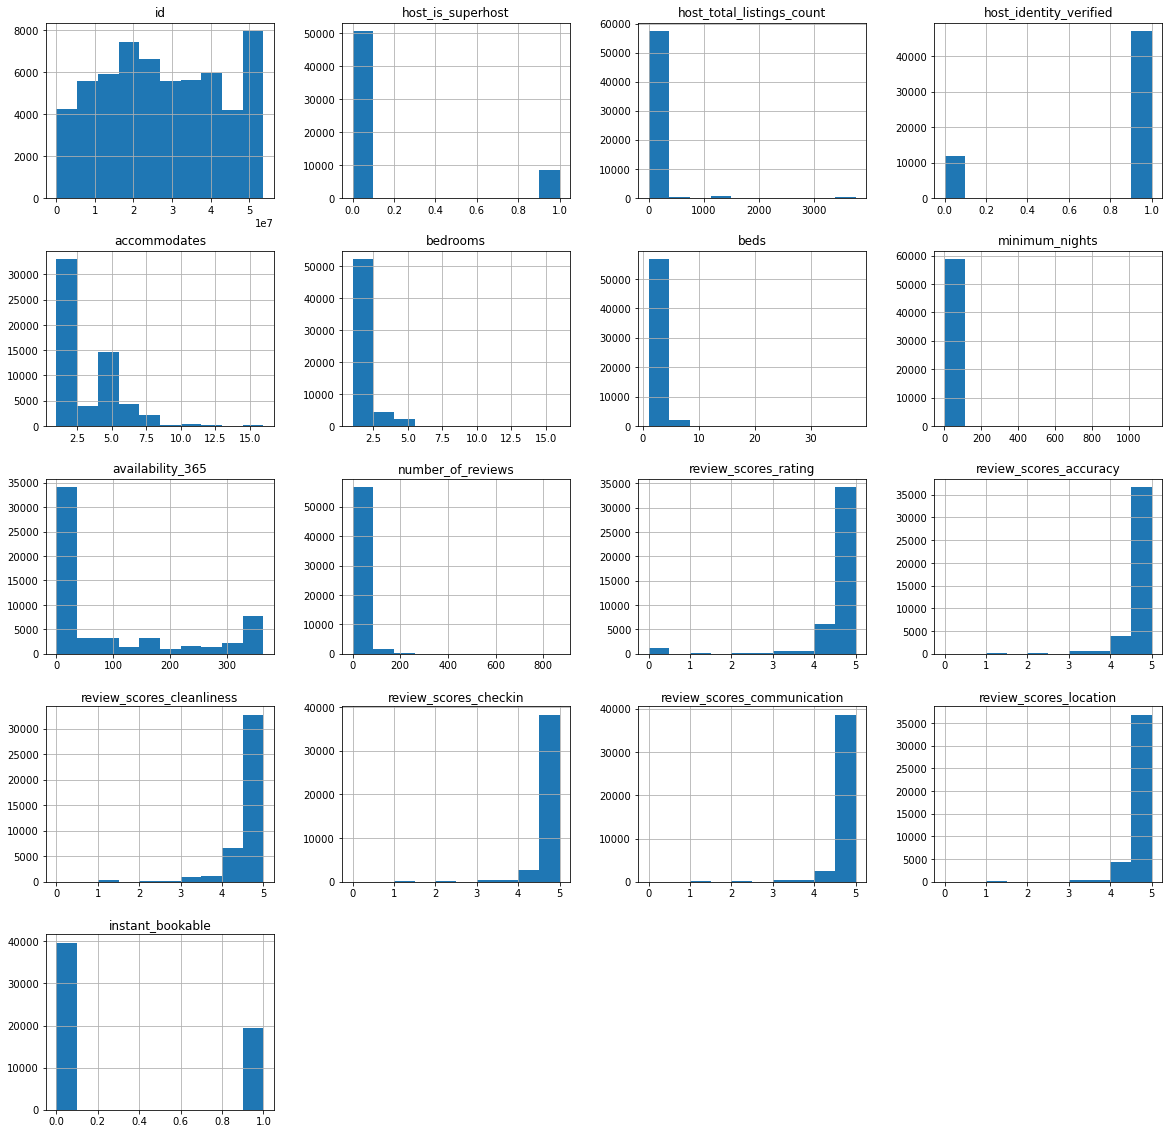

In [8]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [9]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,[ 'host_is_superhost', 'host_total_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

0

In [10]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [11]:
df["bathrooms_text"] = df.bathrooms_text.str.replace(r"\D+", "",regex=True)

In [12]:
df["bathrooms_text"]=df.bathrooms_text.replace('',np.nan).astype(float)

In [13]:
df.head()

,id,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable
1,15400,0,1.0,1,2,1.0,1.0,1.0,75,3,4,89,4.79,4.84,4.88,4.87,4.82,4.93,0
2,17402,0,18.0,1,6,2.0,3.0,3.0,265,4,295,43,4.69,4.80,4.68,4.66,4.66,4.85,0
3,17506,0,3.0,1,2,1.0,1.0,1.0,150,3,364,0,NaN,NaN,NaN,NaN,NaN,NaN,0
5,33332,0,2.0,1,2,1.0,1.0,1.0,65,2,362,11,4.55,4.50,4.60,4.70,4.80,4.80,0
6,36299,0,1.0,1,5,15.0,3.0,3.0,195,3,300,86,4.82,4.81,4.80,4.94,4.96,4.90,0


Determine data types of each column to ensure that a graph for feature importance can be plotted

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59127 entries, 1 to 66640
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           59127 non-null  int64  
 1   host_is_superhost            59127 non-null  int64  
 2   host_total_listings_count    59127 non-null  float64
 3   host_identity_verified       59127 non-null  int64  
 4   accommodates                 59127 non-null  int64  
 5   bathrooms_text               58882 non-null  float64
 6   bedrooms                     59127 non-null  float64
 7   beds                         59127 non-null  float64
 8   price                        59127 non-null  int64  
 9   minimum_nights               59127 non-null  int64  
 10  availability_365             59127 non-null  int64  
 11  number_of_reviews            59127 non-null  int64  
 12  review_scores_rating         43376 non-null  float64
 13  review_scores_ac

In [15]:
df = df.set_index('id')

Limit prices to £1000

In [16]:
maxVal = 1000
df['price'][df['price'] >= maxVal] = maxVal

Replace NaN values in review scores columns with 0 and drop NaN values in other columns

In [17]:
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)
df['review_scores_accuracy'] = df['review_scores_accuracy'].fillna(0)
df['review_scores_cleanliness'] = df['review_scores_cleanliness'].fillna(0)
df['review_scores_checkin'] = df['review_scores_checkin'].fillna(0)
df['review_scores_communication'] = df['review_scores_communication'].fillna(0)
df['review_scores_location'] = df['review_scores_location'].fillna(0)


df = df.dropna(subset = ["host_is_superhost", "host_total_listings_count", "bathrooms_text", "bedrooms", "beds"])

In [18]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

<a id="Decision"></a>
## Feature Importance using Decision Tree

In [19]:
# Putting feature variable to X
X = df.drop('price',axis=1)

# Putting response variable to y
y = df['price']

Import train-test split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((41217, 17), (17665, 17))

Import DecisionTreeClassifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 43)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=43)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [25]:
dt = DecisionTreeClassifier(random_state=43)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=43)

In [26]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [27]:
print(accuracy_score(y_train, y_train_pred))
confusion_matrix(y_train, y_train_pred)

0.8829123905184754


array([[  2,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,  20, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   1,   0,   0],
       [  0,   0,   0, ...,   0,   7,   0],
       [  0,   0,   0, ...,   0,   0, 623]])

In [28]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.04443815454288141


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   1,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   1,   0, ...,   0,   0, 126]])

In [29]:
# Checking the overall accuracy.
trainaccuracy= accuracy_score(y_train, y_train_pred)
testaccuracy= accuracy_score(y_test, y_test_pred)

confusion_TRN = confusion_matrix(y_train, y_train_pred)
confusion_TST = confusion_matrix(y_test, y_test_pred)

Check the confusion matrix (true positive/negative, false positive/negative)

In [30]:
TP = confusion_TRN[1,1] # true positive 
TN = confusion_TRN[0,0] # true negatives
FP = confusion_TRN[0,1] # false positives
FN = confusion_TRN[1,0] # false negatives

TP_TST = confusion_TST[1,1] # true positive 
TN_TST = confusion_TST[0,0] # true negatives
FP_TST = confusion_TST[0,1] # false positives
FN_TST = confusion_TST[1,0] # false negatives

trainsensitivity= TP / float(TP+FN)
trainspecificity= TN / float(TN+FP)

testsensitivity= TP_TST / float(TP_TST+FN_TST)
testspecificity= TN_TST / float(TN_TST+FP_TST)

# Let us compare the values obtained for Train & Test:
print('-'*30)
print('On Train Data')
print('-'*30)
print("Accuracy    : {} %".format(round((trainaccuracy*100),2)))
print("Sensitivity : {} %".format(round((trainsensitivity*100),2)))
print("Specificity : {} %".format(round((trainspecificity*100),2)))
print('-'*30)
print('On Test Data')
print('-'*30)
print("Accuracy    : {} %".format(round((testaccuracy*100),2)))
print("Sensitivity : {} %".format(round((testsensitivity*100),2)))
print("Specificity : {} %".format(round((testspecificity*100),2)))
print('-'*30)

------------------------------
On Train Data
------------------------------
Accuracy    : 88.29 %
Sensitivity : nan %
Specificity : 100.0 %
------------------------------
On Test Data
------------------------------
Accuracy    : 4.44 %
Sensitivity : 100.0 %
Specificity : nan %
------------------------------


/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/742187470.py:11: RuntimeWarning: invalid value encountered in true_divide
  trainsensitivity= TP / float(TP+FN)
/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/742187470.py:15: RuntimeWarning: invalid value encountered in true_divide
  testspecificity= TN_TST / float(TN_TST+FP_TST)


Import the GridSearchCV to check the best parameters for Decision Tree

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
dt_hp = DecisionTreeClassifier(random_state=43)

params = {'max_depth':[3,5,7,10],
          'min_samples_leaf':[5,10,15,20],
          'min_samples_split':[10,12,18,20],
          'criterion':['gini','entropy']}
GS = GridSearchCV(estimator=dt_hp,param_grid=params,cv=5,n_jobs=-1, verbose=True, scoring='accuracy')

In [33]:
GS.fit(X_train, y_train)

/Users/joelle/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=43), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [10, 12, 18, 20]},
             scoring='accuracy', verbose=True)

In [34]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}

Best Score: 0.06366312427882732


In [35]:
dt_hp = DecisionTreeClassifier(max_depth= 9,min_samples_leaf= 25, min_samples_split=5 ,random_state=43)

In [36]:
dt_hp.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=25, min_samples_split=5,
                       random_state=43)

In [37]:
y_train_pred = dt_hp.predict(X_train)
y_test_pred = dt_hp.predict(X_test)

# Let's check the overall accuracy.
trainaccuracy= accuracy_score(y_train, y_train_pred)
testaccuracy= accuracy_score(y_test, y_test_pred)

confusion_TRN = confusion_matrix(y_train, y_train_pred)
confusion_TST = confusion_matrix(y_test, y_test_pred)

TP = confusion_TRN[1,1] # true positive 
TN = confusion_TRN[0,0] # true negatives
FP = confusion_TRN[0,1] # false positives
FN = confusion_TRN[1,0] # false negatives

TP_TST = confusion_TST[1,1] # true positive 
TN_TST = confusion_TST[0,0] # true negatives
FP_TST = confusion_TST[0,1] # false positives
FN_TST = confusion_TST[1,0] # false negatives

trainsensitivity= TP / float(TP+FN)
trainspecificity= TN / float(TN+FP)

testsensitivity= TP_TST / float(TP_TST+FN_TST)
testspecificity= TN_TST / float(TN_TST+FP_TST)

# Let us compare the values obtained for Train & Test:
print('-'*30)
print('On Train Data')
print('-'*30)
print("Accuracy    : {} %".format(round((trainaccuracy*100),2)))
print("Sensitivity : {} %".format(round((trainsensitivity*100),2)))
print("Specificity : {} %".format(round((trainspecificity*100),2)))
print('-'*30)
print('On Test Data')
print('-'*30)
print("Accuracy    : {} %".format(round((testaccuracy*100),2)))
print("Sensitivity : {} %".format(round((testsensitivity*100),2)))
print("Specificity : {} %".format(round((testspecificity*100),2)))
print('-'*30)

------------------------------
On Train Data
------------------------------
Accuracy    : 8.9 %
Sensitivity : nan %
Specificity : nan %
------------------------------
On Test Data
------------------------------
Accuracy    : 6.04 %
Sensitivity : nan %
Specificity : nan %
------------------------------


/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/1361111424.py:21: RuntimeWarning: invalid value encountered in true_divide
  trainsensitivity= TP / float(TP+FN)
/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/1361111424.py:22: RuntimeWarning: invalid value encountered in true_divide
  trainspecificity= TN / float(TN+FP)
/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/1361111424.py:24: RuntimeWarning: invalid value encountered in true_divide
  testsensitivity= TP_TST / float(TP_TST+FN_TST)
/var/folders/98/_7wkwp_d073bz2gfk33t19hr0000gn/T/ipykernel_2323/1361111424.py:25: RuntimeWarning: invalid value encountered in true_divide
  testspecificity= TN_TST / float(TN_TST+FP_TST)


Creating a dictionary of the features and determine their importance values

In [38]:
# Create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, dt_hp.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [39]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,host_total_listings_count,0.306151
1,accommodates,0.215812
2,minimum_nights,0.121830
3,availability_365,0.089565
4,bathrooms_text,0.054375
5,number_of_reviews,0.051628
6,review_scores_location,0.039544
7,bedrooms,0.030074
8,review_scores_cleanliness,0.017111
9,host_identity_verified,0.014865


Plot bar chart of features in order of their importance in influencing prices

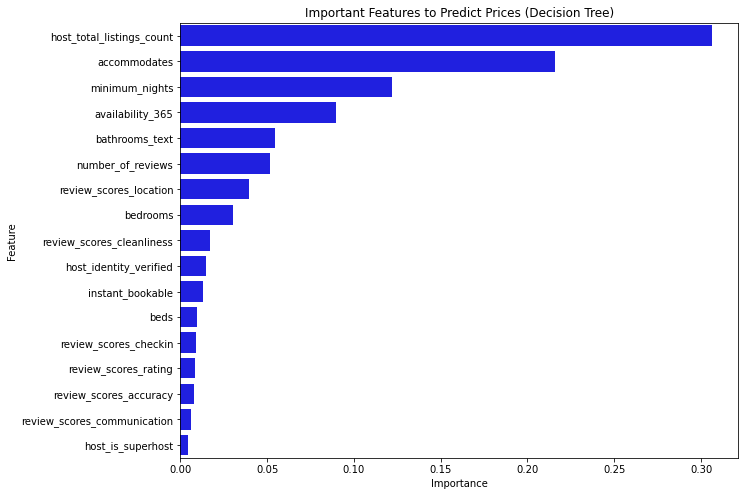

In [40]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['blue']
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important Features to Predict Prices (Decision Tree)')
plt.show()

<a id="Forest"></a>
## Feature Importance using Random Forest Regression 

In [41]:
# Putting feature variable to X
X = df.drop('price',axis=1)

# Putting response variable to y
y = df['price']

Import train-test split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((41217, 17), (17665, 17))

Import RandomForestClassifier

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Creating and fitting the model
RF = RandomForestRegressor(n_estimators=2000, max_depth=40,min_samples_split = 50,
                           max_leaf_nodes = 70,max_features = 5)

RF.fit(X_train, y_train)
# Predicting the training and testing sets
trainPredictin_RF = RF.predict(X_train)
testPredictin_RF =RF.predict(X_test)

In [ ]:
# The model accurracies and validation analysis
trainPredictin_RF = RF.predict(X_train)
testPredictin_RF =RF.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, trainPredictin_RF),
        mean_squared_error(y_test, testPredictin_RF)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, trainPredictin_RF),
        r2_score(y_test, testPredictin_RF)))

Creating feature importance

In [ ]:
importancesRF = RF.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Importance'], index= X_train.columns)
feat_imp1.sort_values(by=['Importance'], ascending= False, inplace=True)
feat_imp1

In [ ]:
feat_imp = pd.DataFrame({'Importance':RF.feature_importances_})  #creating a data of the features and importance 
feat_imp['Feature'] = X_train.columns

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

feat_imp = feat_imp[["Feature", "Importance"]]
feat_imp

Plot bar chart of features in order of their importance in influencing prices

In [ ]:
values = feat_imp.Importance    
idx = feat_imp.Feature
plt.figure(figsize=(10,8))
clrs = ['blue']
sns.barplot(y=idx,x=values,palette=clrs).set(title= 'Important Features to Predict Prices (Random Forest Regression)')
plt.show()